# Import Packages

In [74]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [75]:
X = pd.read_csv('data/train_values.csv', index_col='patient_id')

In [76]:
X.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


We can see from the above output that our dataset have three types of features catagorical, numerical and binary features. We will separate those features.

In [6]:
numerical_features = ['slope_of_peak_exercise_st_segment', 
                      'resting_blood_pressure', 
                      'num_major_vessels',
                      'fasting_blood_sugar_gt_120_mg_per_dl',
                      'serum_cholesterol_mg_per_dl',
                      'oldpeak_eq_st_depression',
                      'age',
                      'max_heart_rate_achieved']

categorical_features = ['thal',
                        'chest_pain_type', 
                        'resting_ekg_results']

binary_features = ['sex',
                   'exercise_induced_angina']

# Import label

In [7]:
y = pd.read_csv('data/train_labels.csv', index_col='patient_id')['heart_disease_present']

# Correlation plot for features

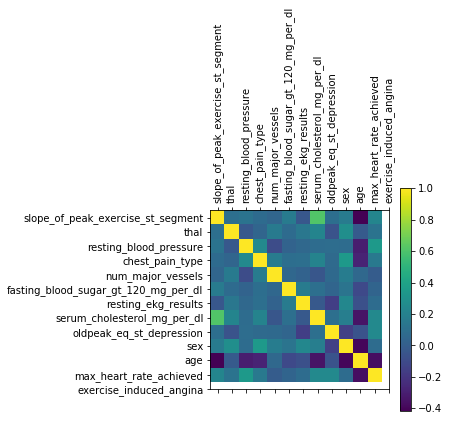

In [8]:
plt.matshow(X.corr())
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.yticks(range(X.shape[1]), X.columns)
plt.colorbar()
plt.show();

Above plot shows the correlation between the different features of the given data. More bluish means there is low correlation and yellowish means there is a high correlation.

Now, let us see the violin plots of the all of the features. From these plots we can determine that how that particular feture is going to affect the label. If the violin plot look similar it means that feature is not much significant in the detection of the disease.

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


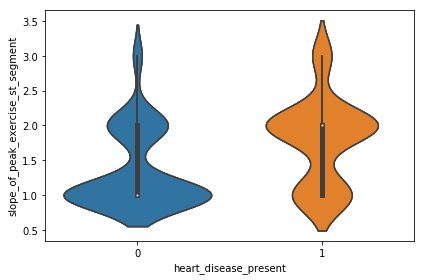

In [11]:
sns.violinplot(y,X['slope_of_peak_exercise_st_segment'])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


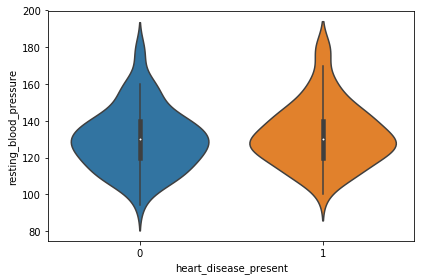

In [12]:
sns.violinplot(y,X['resting_blood_pressure'])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


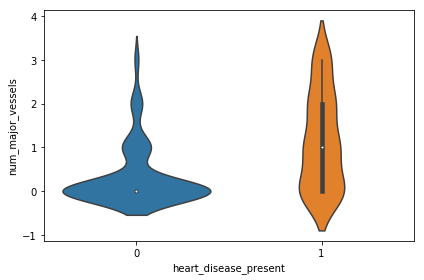

In [14]:
sns.violinplot(y,X[numerical_features[2]])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


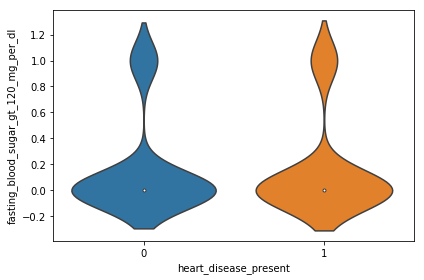

In [16]:
sns.violinplot(y,X[numerical_features[3]])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


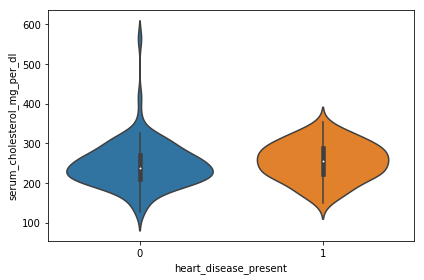

In [18]:
sns.violinplot(y,X[numerical_features[4]])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


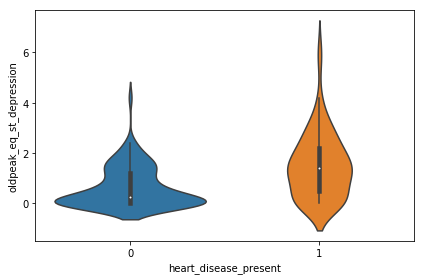

In [19]:
sns.violinplot(y,X[numerical_features[5]])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


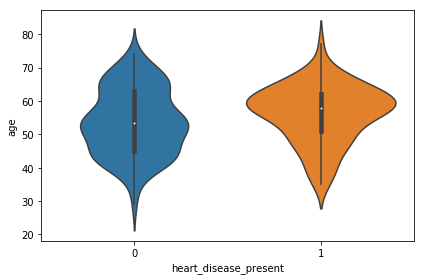

In [20]:
sns.violinplot(y,X[numerical_features[6]])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


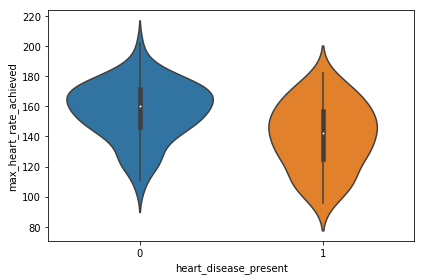

In [21]:
sns.violinplot(y,X[numerical_features[7]])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


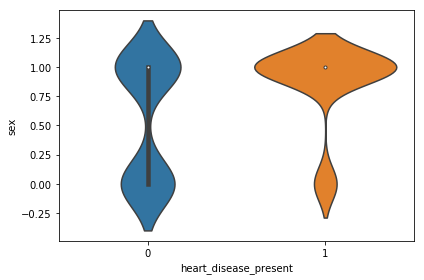

In [26]:
sns.violinplot(y,X[binary_features[0]])
plt.tight_layout()
plt.show()

C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\surjeet\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


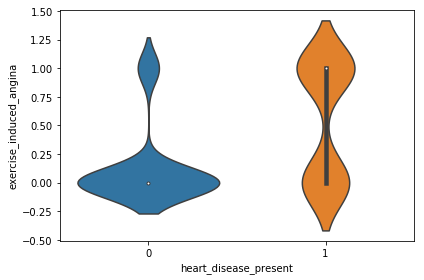

In [27]:
sns.violinplot(y,X[binary_features[1]])
plt.tight_layout()
plt.show()

All of the above plots can be made at once just by using the following code.

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=len(numerical_features), figsize=(10, 70))

for column in numerical_features:
    ax_num = list(X[numerical_features]).index(column)
    sns.violinplot(y, X[column], ax=ax[ax_num])
    
plt.tight_layout()

# Transformers

As we have seen that our data has some categorical features which we need to transform into the numerical values. We have to use the column transformer for that job. I have illustrated below, what it returns after executing.

In [30]:
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X[self.columns]
    
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.labelers = {col: LabelEncoder().fit(X[col]) for col in X}
        return self
    
    def transform(self, X):
        return pd.DataFrame({col: self.labelers[col].transform(X[col])
                            for col in X})

### Illustration of the above transformer

In [64]:
tahl_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(["thal"])),
    ('cle', CustomLabelEncoder()),
    ('ohe', OneHotEncoder(categories = "auto",sparse=False))
])

In [88]:
tahl_pipe.fit_transform(X)[0:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

This array has three columns becuase it has three unique values which can be verified by the following code.

In [86]:
len(X["thal"].unique())

3

The __thal__ column in the dataframe is converted into array as shown above. The interpretation of the above array is that <br/> __normal = [0. 1. 0.], reversible_defect = [0. 0. 1.]__ and __fixed_defect = [1. 0. 0.]__.

# Logistic Regression

In [89]:
# For categorical features
cat_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(categorical_features)),
    ('cle', CustomLabelEncoder()),
    ('ohe', OneHotEncoder(sparse=False))
])

# For features we don't want to transform
passthrough_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(numerical_features + binary_features))
])

# combining the above pipelines
feat_u = FeatureUnion([
    ('cat_pipe', cat_pipe),
    ('passthrough_pipe', passthrough_pipe)
])

In [94]:
# combining the pipelines and the logistic regression
full_model = Pipeline([
    ('feat_u', feat_u),
    ('lr', LogisticRegression())
])

In [91]:
full_model.fit(X, y)

C:\Users\surjeet\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\surjeet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('feat_u',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cat_pipe',
                                                 Pipeline(memory=None,
                                                          steps=[('cst',
                                                                  ColumnSelectTransformer(columns=['thal',
                                                                                                   'chest_pain_type',
                                                                                                   'resting_ekg_results'])),
                                                                 ('cle',
                                                                  CustomLabelEncoder()),
                                                                 ('ohe',
                                                                  OneHotEncoder(categorical_features=None,
           

In [92]:
# predicting the probability for the given data
y_pred = full_model.predict_proba(X)

In [93]:
# calculating the log loss
log_loss(y, y_pred, labels = None)

0.3423304810725902

Lesser the value of the log loss fuction better our model is.

Now importing the test data provided by the drivedata.org as __X_test__.

In [46]:
X_test = pd.read_csv('data/test_values.csv', index_col='patient_id')

Predicting the label probability ( probability of presence of heart disease) for the test data.

In [52]:
y_pred_test = full_model.predict_proba(X_test)

In [53]:
y_ans = y_pred_test

Exporting the prediction as csv file.

In [97]:
submission = pd.read_csv('data/submission_format.csv')
submission.heart_disease_present = y_ans
submission.to_csv('2019-08-18_submission.csv', index=False)

In [100]:
X.columns

Index(['slope_of_peak_exercise_st_segment', 'thal', 'resting_blood_pressure',
       'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina'],
      dtype='object')

# Reduced Logistic Regression

Here we are reducing the features which are less important. We will select only three columns 

In [101]:
reduced_cols = ['num_major_vessels',
                'slope_of_peak_exercise_st_segment',
                'max_heart_rate_achieved',
                'exercise_induced_angina',
                'age',
                'oldpeak_eq_st_depression',]

simple_lr = LogisticRegression()

simple_lr.fit(X[reduced_cols],y)

y_pred = simple_lr.predict_proba(X[reduced_cols])
log_loss(y, y_pred, labels = None)

C:\Users\surjeet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4460968046007101

In [104]:
# predicting over the test dataset
y_pred_test = simple_lr.predict_proba(X_test[reduced_cols])

In [106]:
# exporting the file into required format
submission = pd.read_csv('data/submission_format.csv')
submission.heart_disease_present = y_pred_test
submission.to_csv('2019-08-18_reduced_submission.csv', index=False)

In [32]:
param_grid = {'max_depth': range(3,10),
              'min_samples_split': range(3,11,2),
              'min_samples_leaf': range(3,11,2)}

gs = GridSearchCV(RandomForestClassifier(),
                  param_grid=param_grid,
                  n_jobs=-1,
                  cv=3,
                  verbose=1)

In [29]:
gs.fit(X, y)

In [ ]:
gs.best_params_

In [ ]:
y_pred = gs.predict(X)

In [ ]:
log_loss(y, y_pred, labels = None)

## Test Values

In [33]:
X_test = pd.read_csv('data/test_values.csv', index_col='patient_id')

In [34]:
y_ans = simple_lr.predict(X_test[reduced_cols])

In [54]:
submission = pd.read_csv('data/submission_format.csv')

In [55]:
submission.heart_disease_present = y_ans

In [56]:
submission.to_csv('2019-08-18_submission.csv', index=False)